# Lens Modeling for DESIJ1101-0602

Authors: S M Rafee Adnan, Janntul Feardous, Anowar J. Shajib


Acknowledgement: Sulyman Hossain

In [1]:
import corner

# import of standard python libraries
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q, shear_cartesian2polar
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Loading Data from h5 Files

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/794900251.py:10: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");


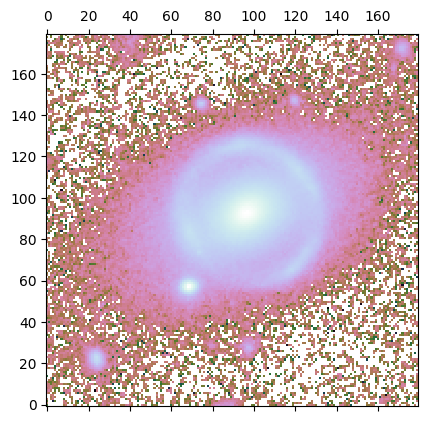

In [2]:
# data specifics

with h5py.File("DESIJ1101-0602_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]
kwargs_data
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

In [3]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [4]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
# beta, n_max, center_x, center_y
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/1854287955.py:95: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/1854287955.py:95: RuntimeWarning: invalid value encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


Text(0.5, 1.0, 'IMAGE AFTER MASKING')

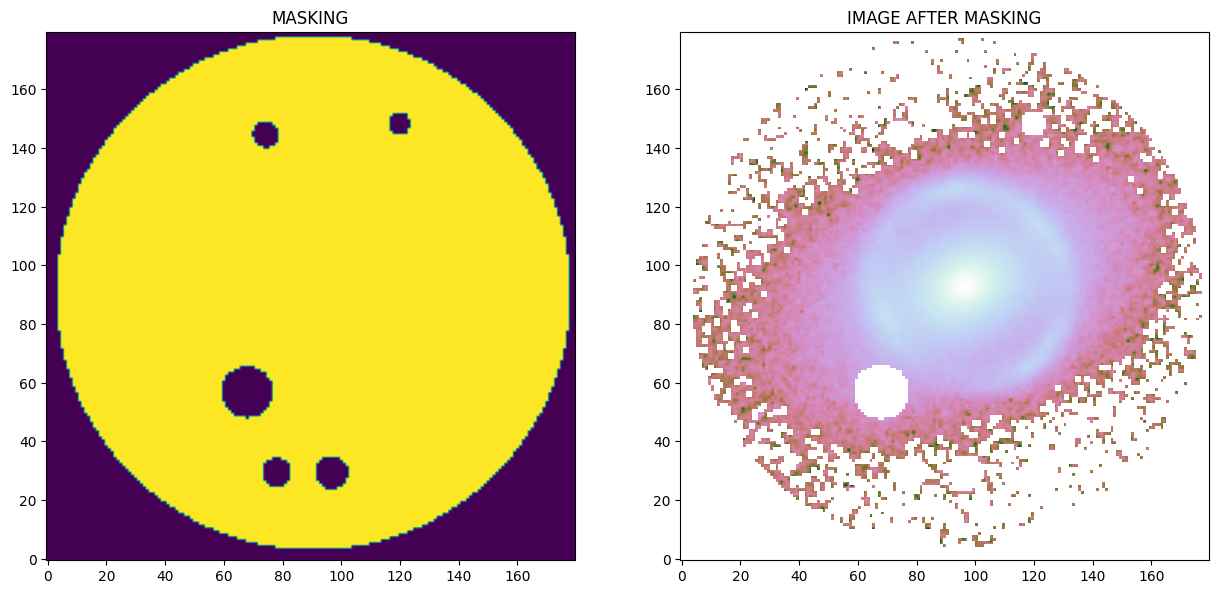

In [5]:
# To make a mask using lenstronomy functions:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 7  # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

# mask_outer_2 = mask_util.mask_center_2d(
#     lens_center_ra,
#     lens_center_dec,
#     r2,
#     util.image2array(x_coords),
#     util.image2array(y_coords),)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.8,
    lens_center_dec - 2.7,
    0.7,
    0.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.34,
    lens_center_dec + 4.6,
    0.3,
    0.3,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3,
    lens_center_dec + 4.3,
    0.35,
    0.35,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec - 4.9,
    0.45,
    0.45,
    0,
)
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1,
    lens_center_dec - 4.9,
    0.4,
    0.4,
    0,
)

mask_1 = (1 - mask_outer_1) * (1 - mask_ext_1)
mask_2 = (1 - mask_ext_2) * (1 - mask_ext_3)
mask_3 = (1 - mask_ext_4) * (1 - mask_ext_5)
mask1 = mask_1 * mask_2 * mask_3
mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0


mask_img = mask1.reshape(num_pix, num_pix)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))


image = np.log10(kwargs_data["image_data"] * mask_img)


plt.sca(axs[0])
plt.imshow(mask_img, origin="lower")
plt.title("MASKING")
# plt.colorbar()


# plt.matshow(np.log10(image), origin="lower", cmap="cubehelix")


plt.sca(axs[1])
plt.imshow(image, origin="lower", cmap="cubehelix")
plt.title("IMAGE AFTER MASKING")

In [10]:
# lens galaxy's mass model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Setting EPL Parameters

fixed_lens.append({"gamma": 2.0})
kwargs_lens_init.append(
    {
        "theta_E": 2.6298,
        "gamma": 2.0,
        "e1": 0.1180,
        "e2": -0.1393,
        "center_x": -0.4889,
        "center_y": 0.2082,
    }
)
kwargs_lens_sigma.append(
    {
        "gamma": 0.1,
        "theta_E": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
    }
)
kwargs_lower_lens.append(
    {
        "gamma": 1.9,
        "theta_E": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "gamma": 3.0,
        "theta_E": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


# Setting SHEAR Parameters

fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.0308, "gamma2": -0.0167})
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

In [11]:
# lens galaxy's light model


fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 1.9266,
        "n_sersic": 4.0,
        "e1": 0.1180,
        "e2": -0.1393,
        "center_x": -0.4889,
        "center_y": 0.2082,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 3.0,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# sersic_2


fixed_lens_light.append({"n_sersic": 1.0})
kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 1.2749,
        "n_sersic": 1.0,
        "e1": 0.1797,
        "e2": -0.1808,
        "center_x": -0.4889,
        "center_y": 0.2082,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 3.0,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [12]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "amp": 1,
        "R_sersic": 0.0979,
        "n_sersic": 1.0,
        "e1": 0.065304688741,
        "e2": -0.109524,
        "center_x": -0.5863734,
        "center_y": 0.160918082,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.008,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.01,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 2.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# add shapelets model to this source model
fixed_source.append({"n_max": 8})
kwargs_source_init.append(
    {"beta": 0.0517, "center_x": -0.586371, "center_y": 0.1609180}
)
kwargs_source_sigma.append({"beta": 0.001, "center_x": 0.1, "center_y": 0.1})
kwargs_lower_source.append({"beta": 0.03, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.2, "center_x": 10, "center_y": 10})

joint_source_with_shapelet = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

In [13]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_shapelet,
}
kwargs_likelihood = {
    "check_bounds": True,
    "image_likelihood_mask_list": [mask_img],
}

kwargs_numerics = {
    "supersampling_factor": 3,
    "supersampling_convolution": False,
}
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [
    [
        kwargs_data,
        kwargs_psf,
        kwargs_numerics,
    ]
]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## PSO: Model Fitting

In [15]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 50, "n_iterations": 100}]
]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

# # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
# # 200, 'sigma_scale': .1}]


# input_ = [
#     fitting_kwargs_list,
#     multi_band_list,
#     kwargs_model,
#     kwargs_constraints,
#     kwargs_likelihood,
#     kwargs_params,
# ]

# fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
# kwargs_result = fitting_seq.best_fit(bijective=False)
# multi_band_list_out = fitting_seq.multi_band_list

# kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs


# # fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
# # kwargs_constraints, kwargs_likelihood, kwargs_params)

# # fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 400,
# #'n_iterations': 700}],
# # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
# # 200, 'sigma_scale': .1}]]

# # chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
# # kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0738733147160082 reduced X^2 of best position
-12573.982642009742 log likelihood
23418 effective number of data points
[{'theta_E': 2.619935317708857, 'gamma': 2.0, 'e1': 0.14633799662385336, 'e2': -0.10237110312408826, 'center_x': -0.4721300609112101, 'center_y': 0.24509363754088972}, {'gamma1': 0.050566704233908126, 'gamma2': 0.00417024239613122, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.19997399510358743, 'n_sersic': 1.0, 'e1': -0.02964377028183644, 'e2': -0.02584308976716078, 'center_x': -0.61061850026261, 'center_y': 0.22136089760427663}, {'amp': 1, 'n_max': 10, 'beta': 0.061737849606500264, 'center_x': -0.61061850026261, 'center_y': 0.22136089760427663}] source result
[{'amp': 1, 'R_sersic': 2.152108199039442, 'n_sersic': 4.0, 'e1': 0.15355854140671785, 'e2': -0.16411221386683472, 'center_x': -0.49049096006103415, 'center_y': 0.19166239611781205}, {'amp': 1, 'R_sersic': 1.

In [16]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ1101-0602_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

-1.0698530265058463 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0698530265058501


/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/4000457043.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


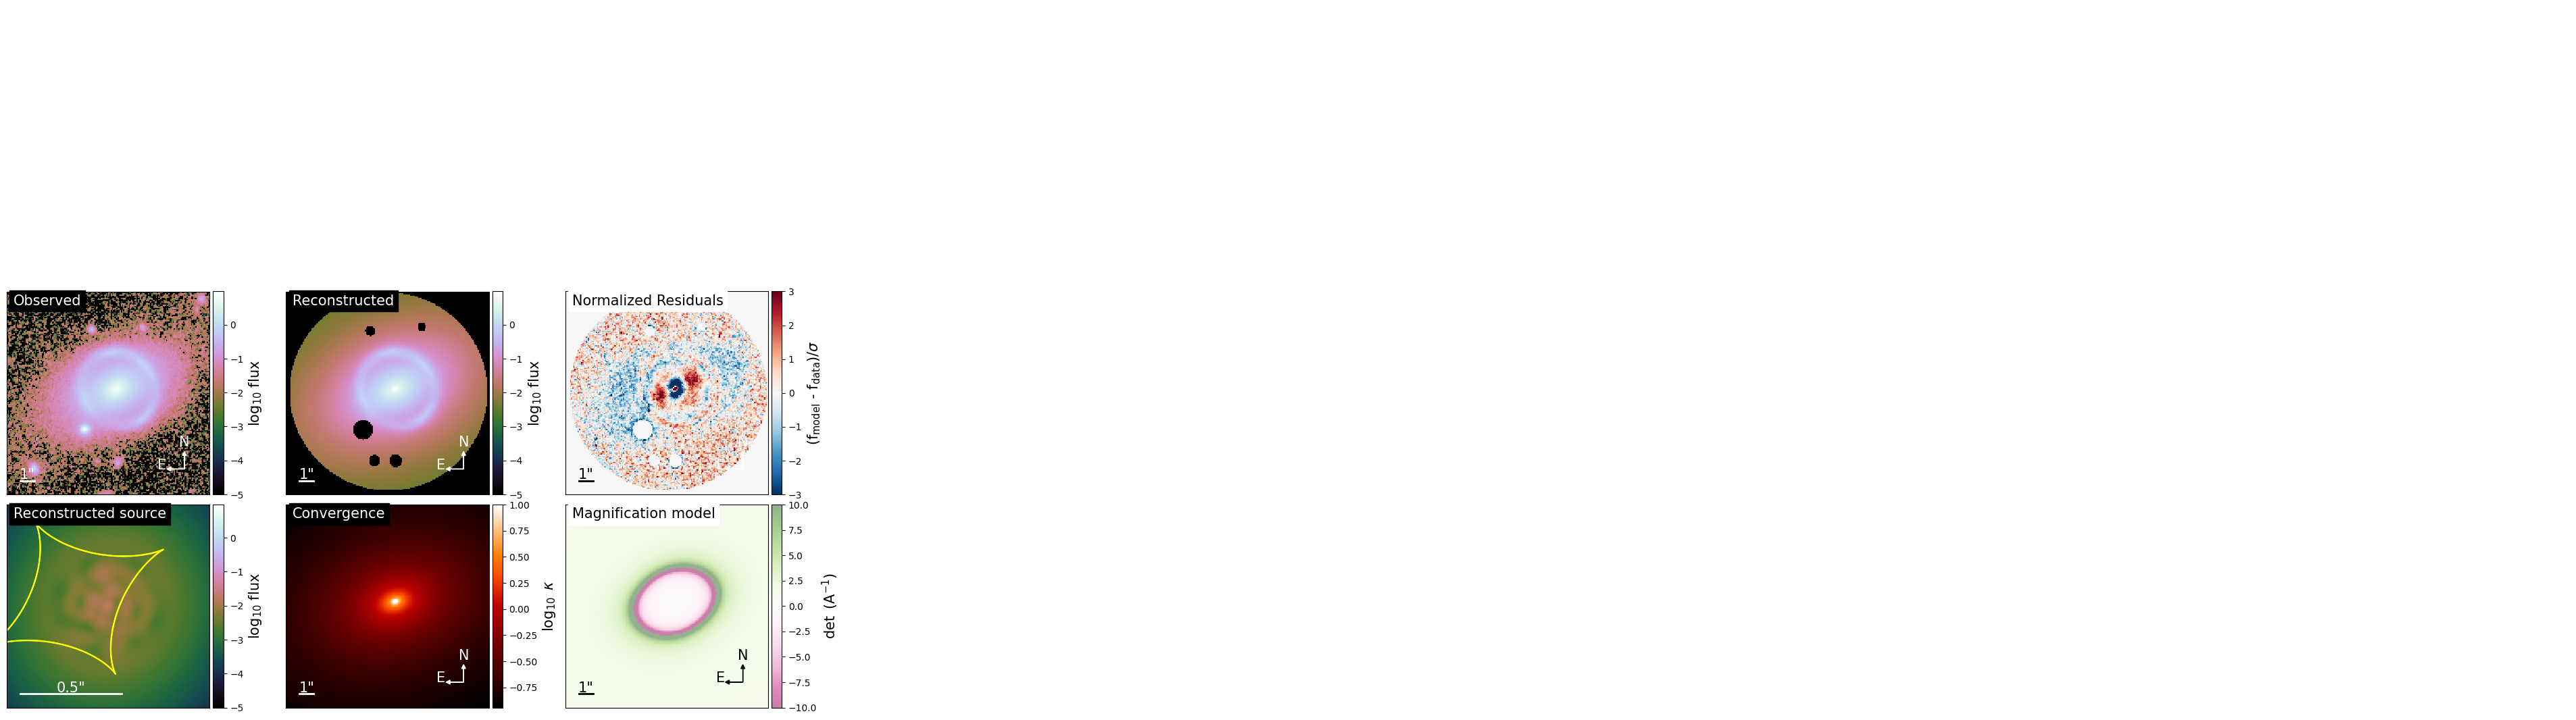

/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


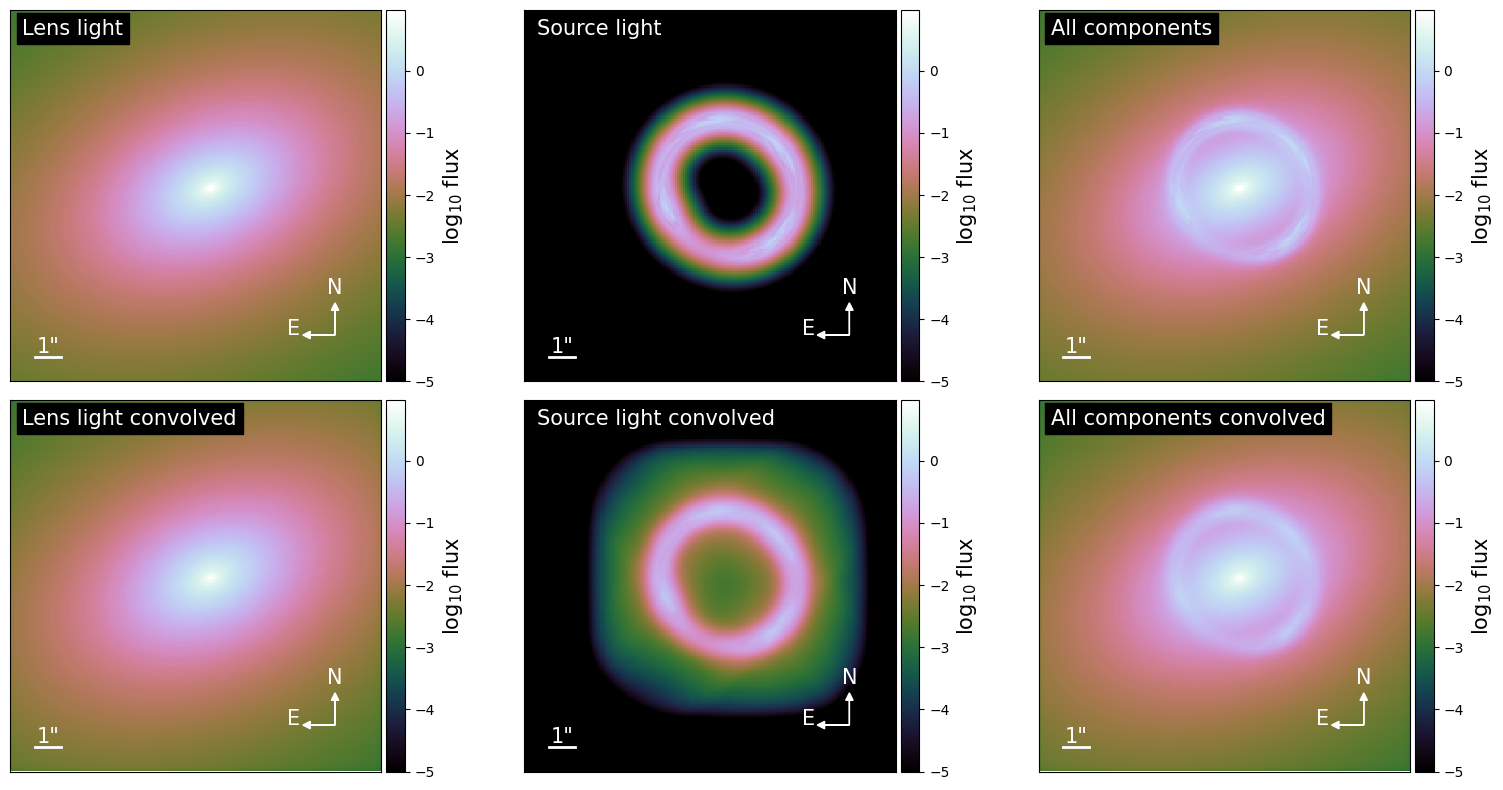

{'kwargs_lens': [{'theta_E': 2.619935317708857, 'gamma': 2.0, 'e1': 0.14633799662385336, 'e2': -0.10237110312408826, 'center_x': -0.4721300609112101, 'center_y': 0.24509363754088972}, {'gamma1': 0.050566704233908126, 'gamma2': 0.00417024239613122, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 95.69254570473638, 'R_sersic': 0.19997399510358743, 'n_sersic': 1.0, 'e1': -0.02964377028183644, 'e2': -0.02584308976716078, 'center_x': -0.61061850026261, 'center_y': 0.22136089760427663}, {'amp': array([-6.91650940e+02,  2.45805622e+01,  1.97658856e+01, -1.70379169e+02,
        1.87847519e+01, -1.81778708e+02, -2.03431139e+01, -6.56594995e+00,
       -2.73807975e+01,  1.90057059e+01, -1.26691806e+02,  1.00830464e+01,
       -1.22065688e+02,  2.25557834e+01, -1.08177367e+02,  1.82901507e+00,
        1.79301879e+01, -2.24357183e+00, -6.75097040e+00, -2.26095700e+00,
        2.27486354e+01, -6.02371004e+01, -6.46878864e+00, -3.96665878e+01,
       -2.54611198e+00, -5.66337214e+01,  1.90275672e

In [17]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

In [18]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

mcmc_backend = "alt_mcmc_backend.h5"


n_walkers = 80
n_step = 5
n_burn = 0

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,

        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)

100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 5
2.1762328147888184 time taken for MCMC sampling


In [19]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

In [20]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly
    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (415360, 19)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (415360, 19)


(415360, 19)
N_step: 5192, N_walkers: 80, N_params: 19


/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/1297989372.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


theta_E_lens0 2.6241 ± 0.0023
e1_lens0 0.1425 ± 0.0039
e2_lens0 -0.1433 ± 0.0048
center_x_lens0 -0.4876 ± 0.0037
center_y_lens0 0.2325 ± 0.0026
gamma1_lens1 0.0398 ± 0.0020
gamma2_lens1 -0.0104 ± 0.0023
R_sersic_source_light0 0.4774 ± 0.0232
e1_source_light0 0.6495 ± 0.0504
e2_source_light0 0.0632 ± 0.0320
center_x_source_light0 -0.5952 ± 0.0079
center_y_source_light0 0.1796 ± 0.0068
beta_source_light1 0.1379 ± 0.0030
R_sersic_lens_light0 0.4992 ± 0.0199
e1_lens_light0 0.1533 ± 0.0011
e2_lens_light0 -0.1690 ± 0.0011
center_x_lens_light0 -0.4896 ± 0.0012
center_y_lens_light0 0.1970 ± 0.0012
R_sersic_lens_light1 1.7942 ± 0.0069


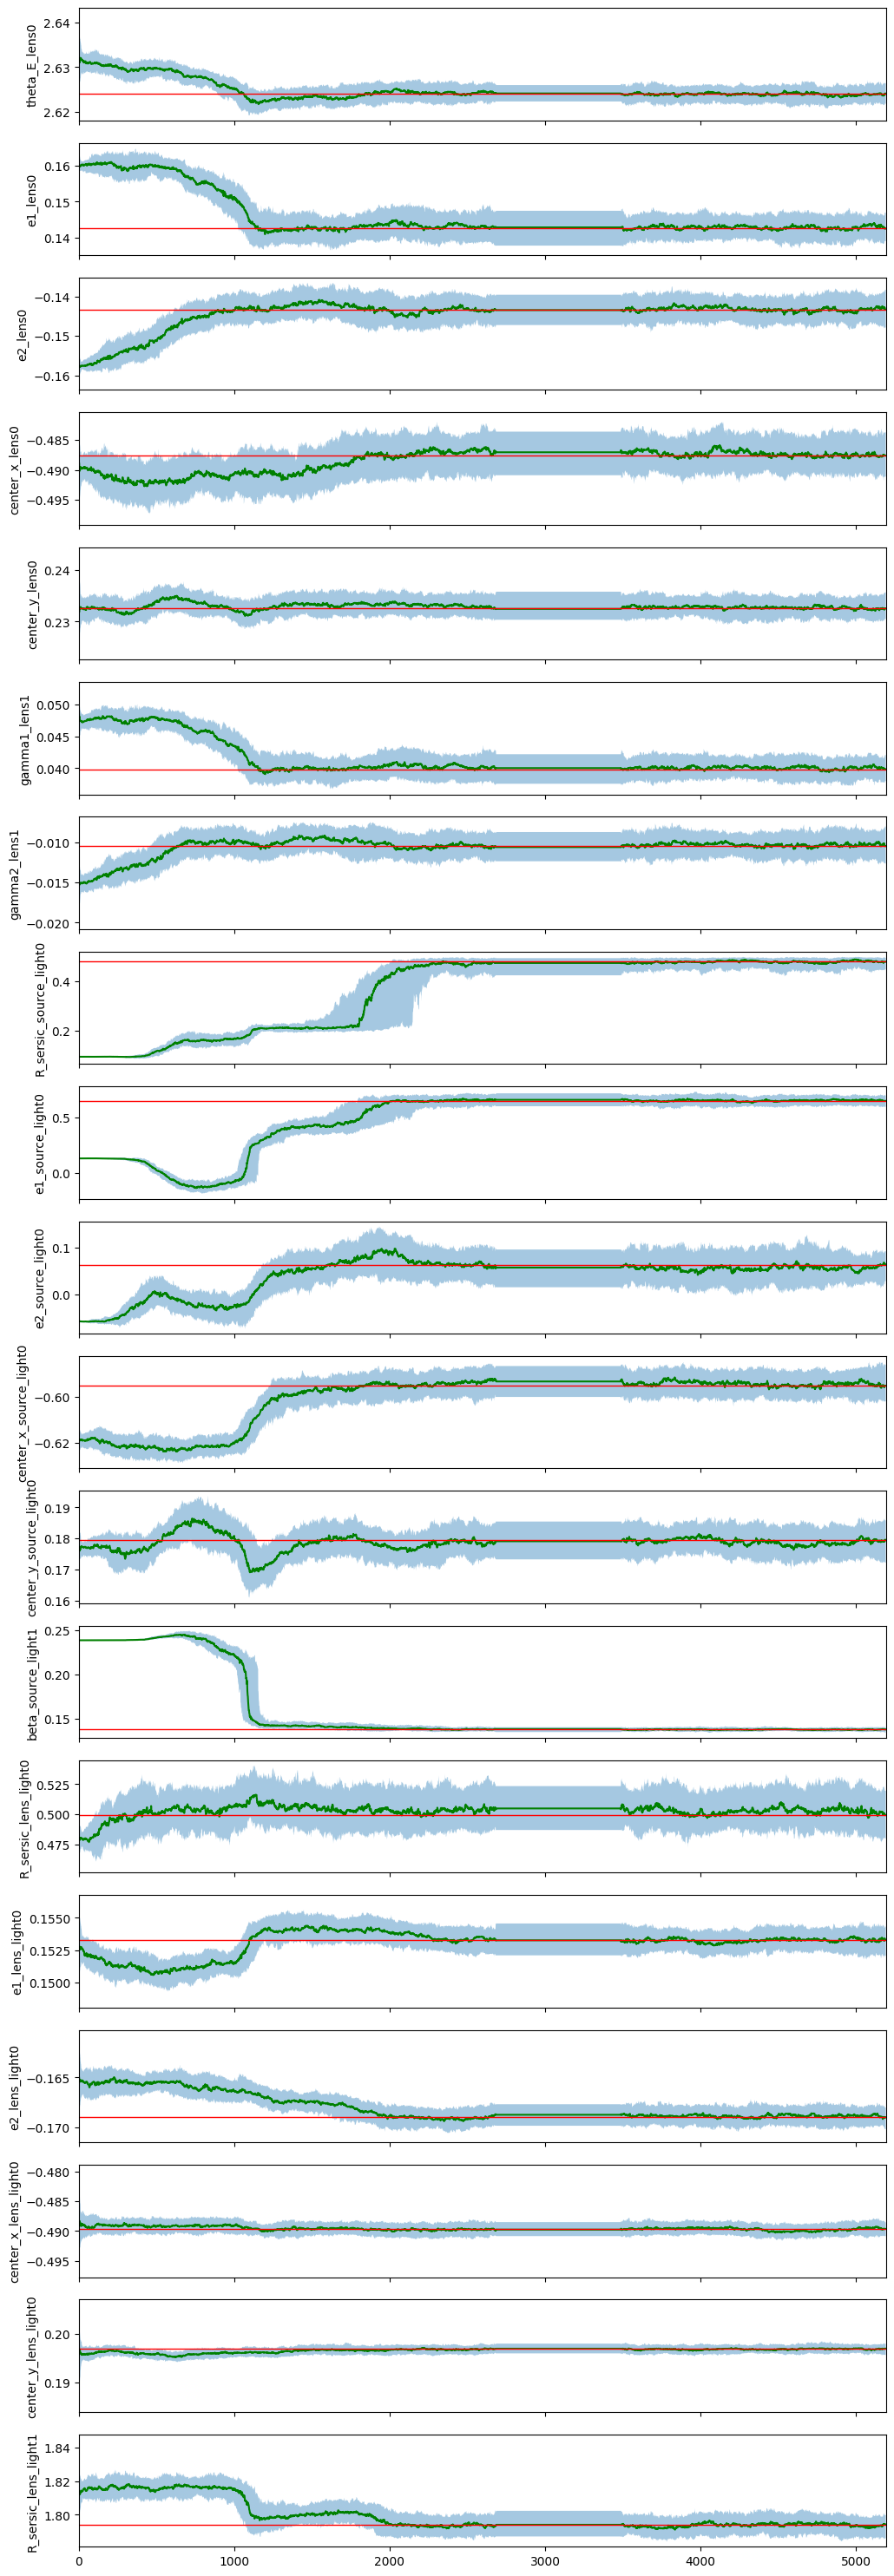

In [21]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc)-mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 80
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    n_burn = 0

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step,
                                                           n_walkers,
                                                           n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order='F')
        chain[:,:,i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1],
                    (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1],
                    (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i],
              '{:.4f} ± {:.4f}'.format(median_pos[i][last-1],
               (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last),
                           q84_pos[i][:last],
                           q16_pos[i][:last],
                           alpha=0.4)

        ax[i].set_ylabel(param_mcmc[i],
                         fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()

Number of non-linear parameters in the MCMC process: 19
Parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Number of evaluations in the MCMC process: 415360
415360
Shape of samples_mcmc_cut: (4000, 19)


/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/317188027.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


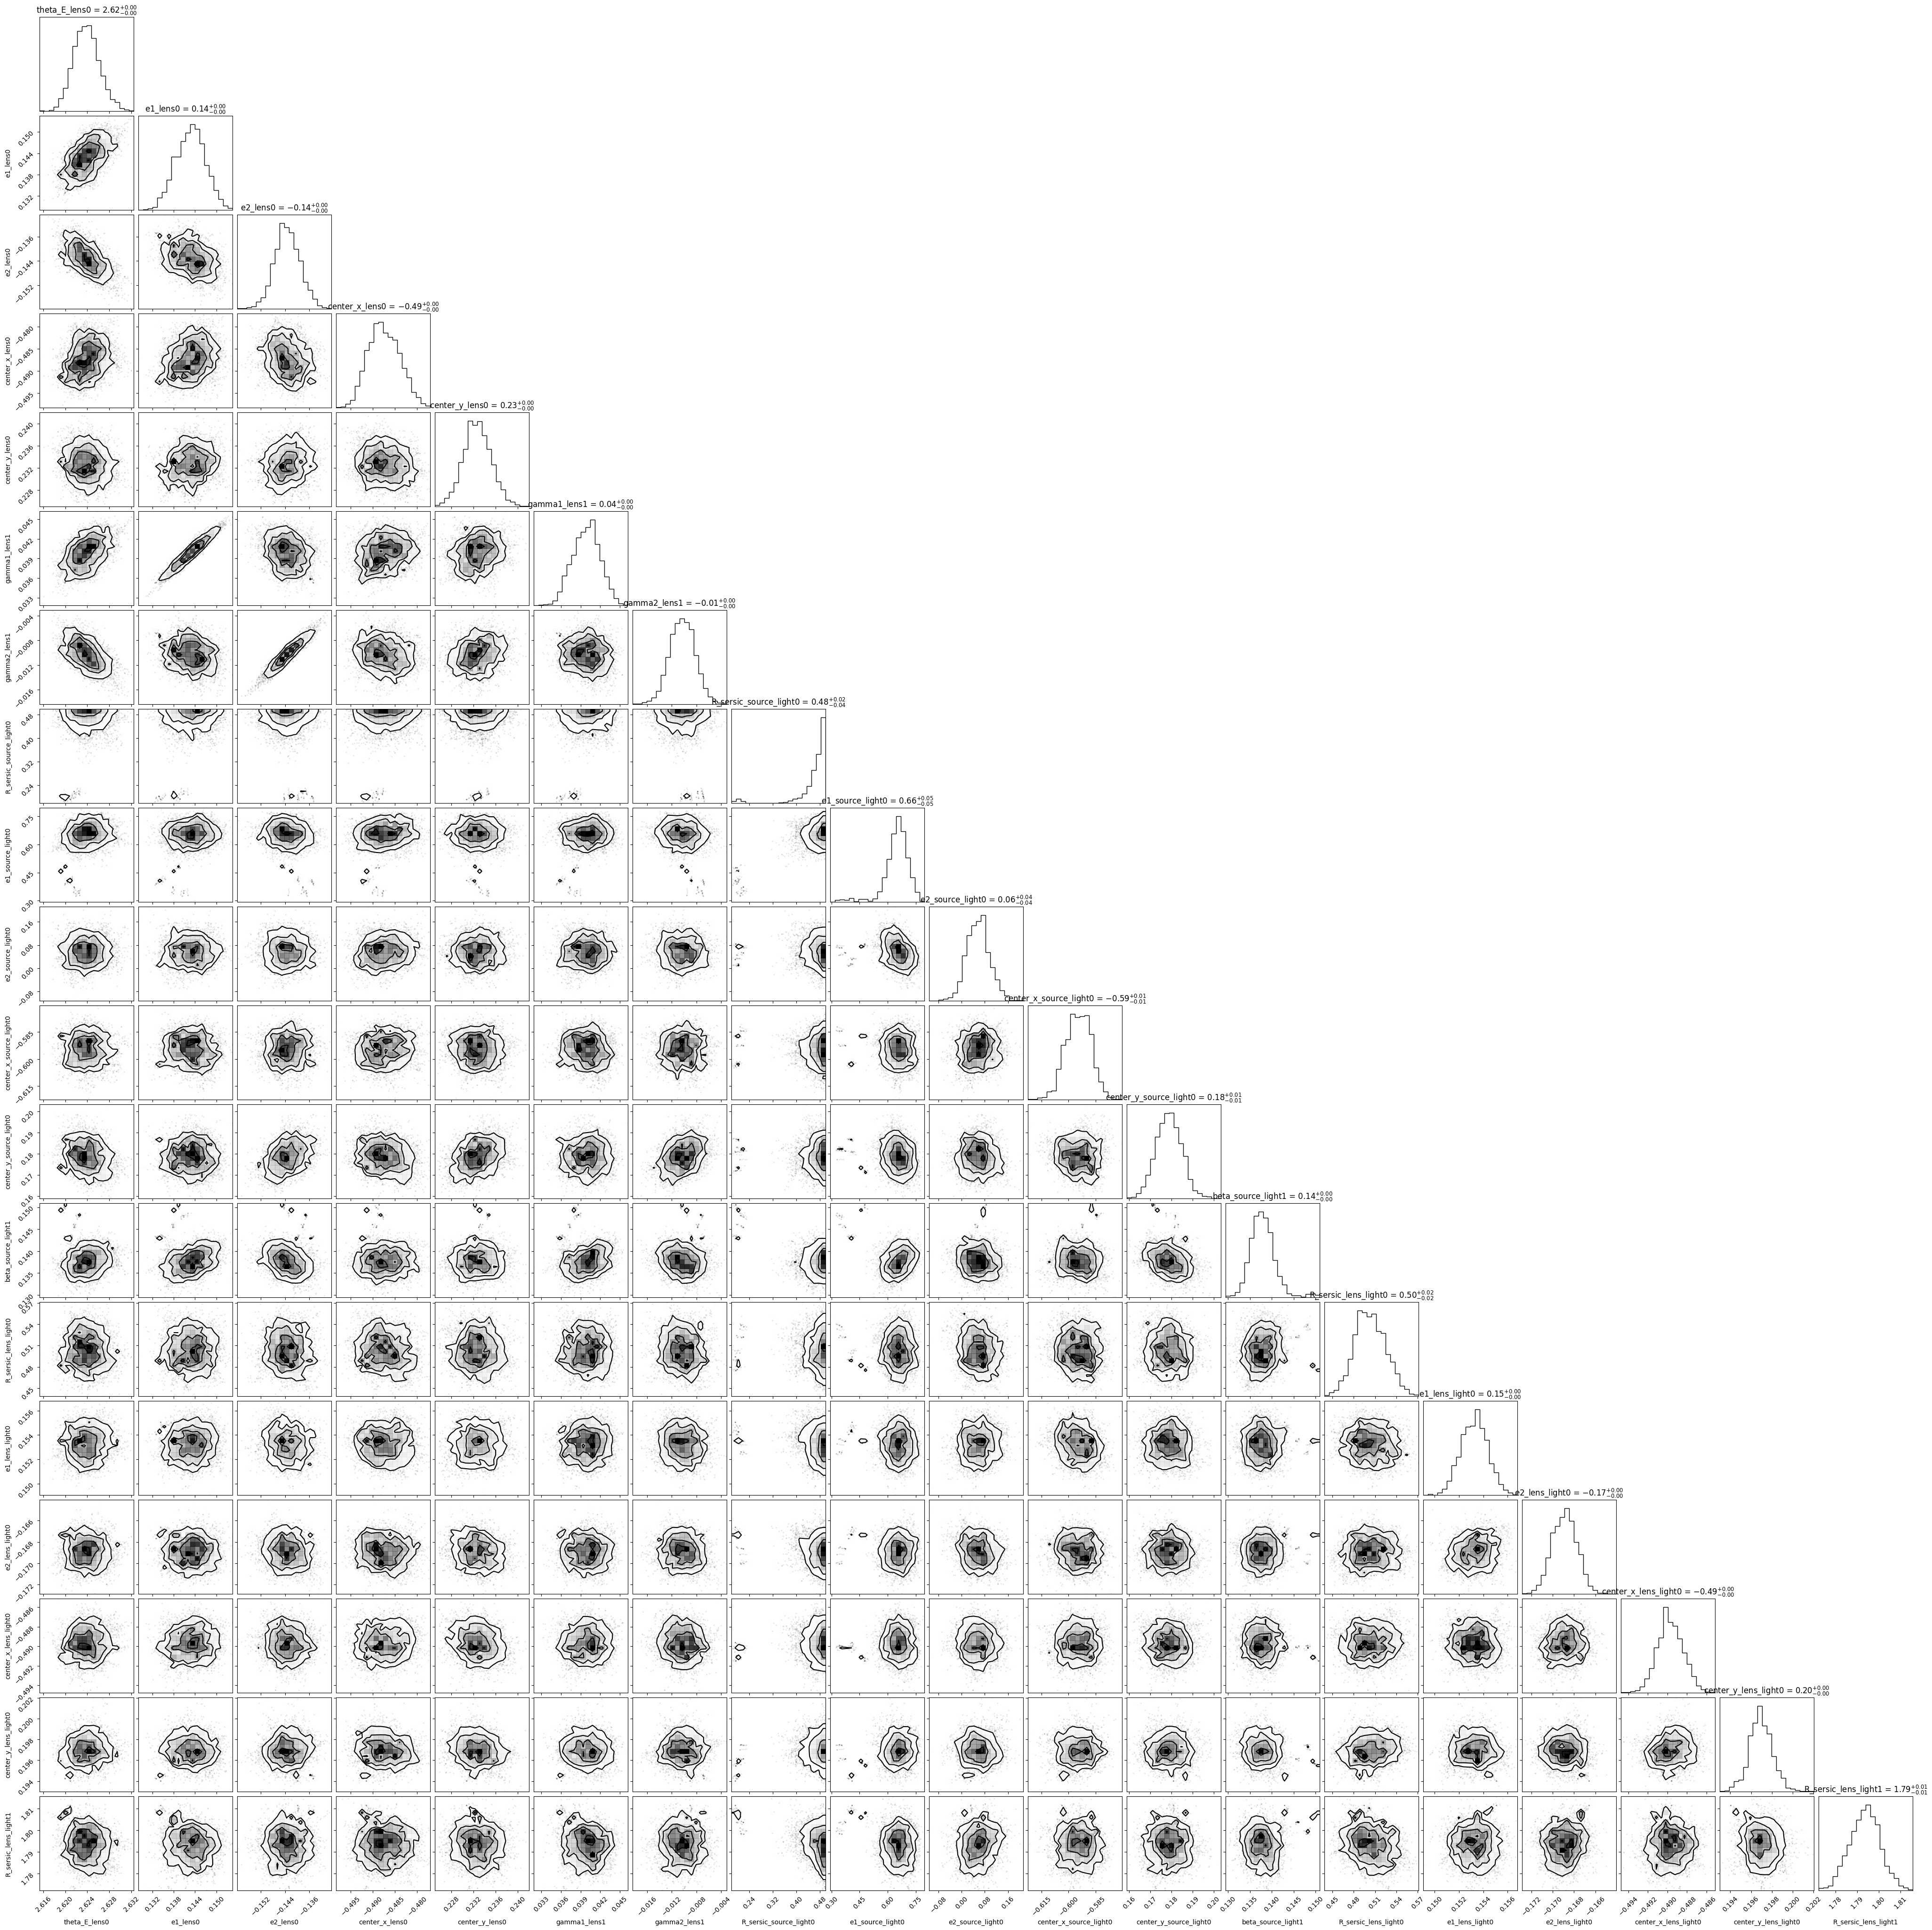

In [22]:
import corner

if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 4692
        thin = 10
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

-1.979435501959158 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.9794355019591598


/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/4220636654.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


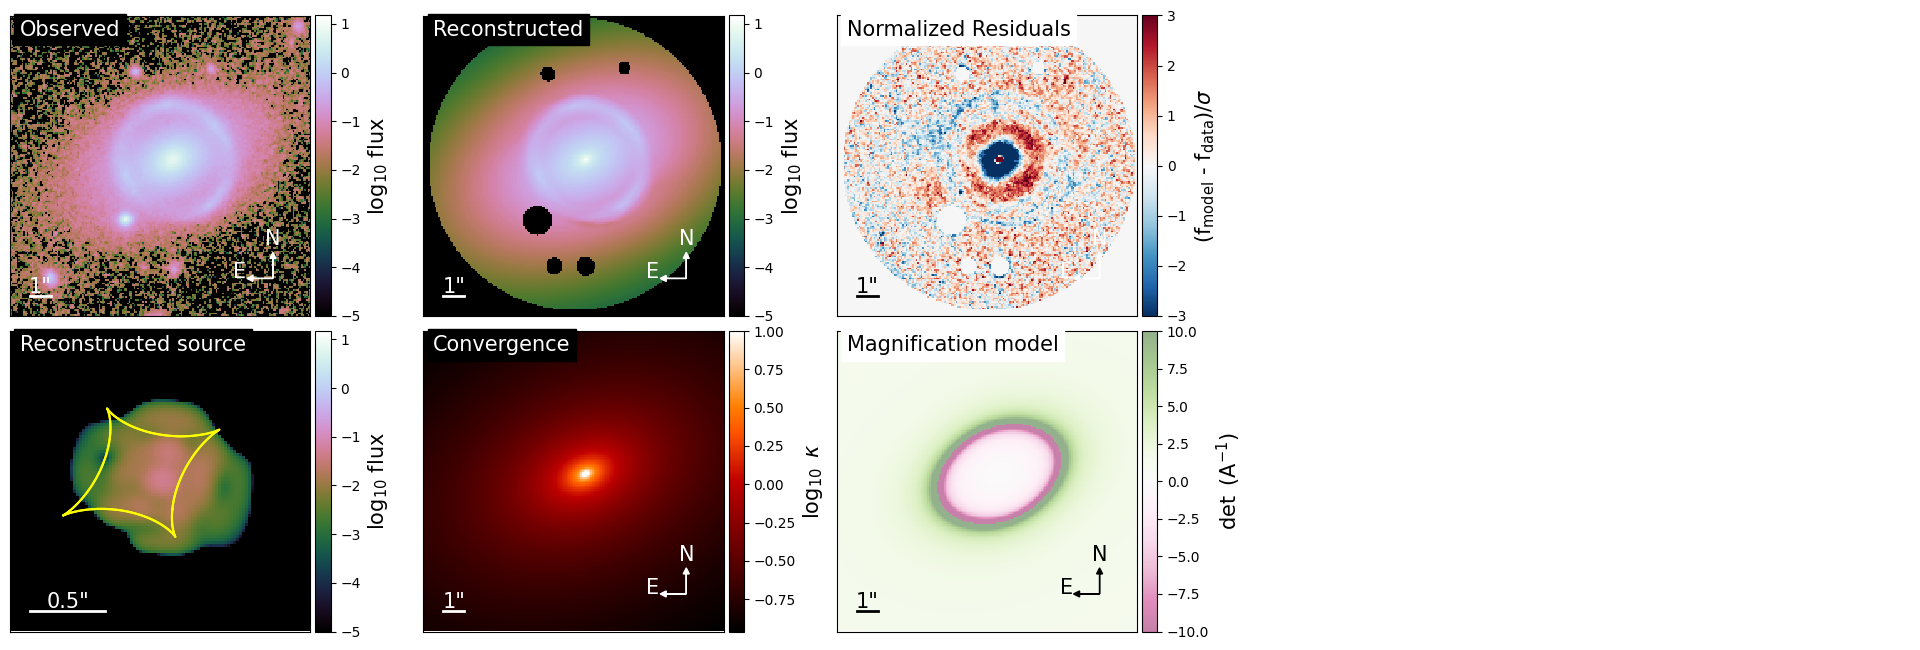

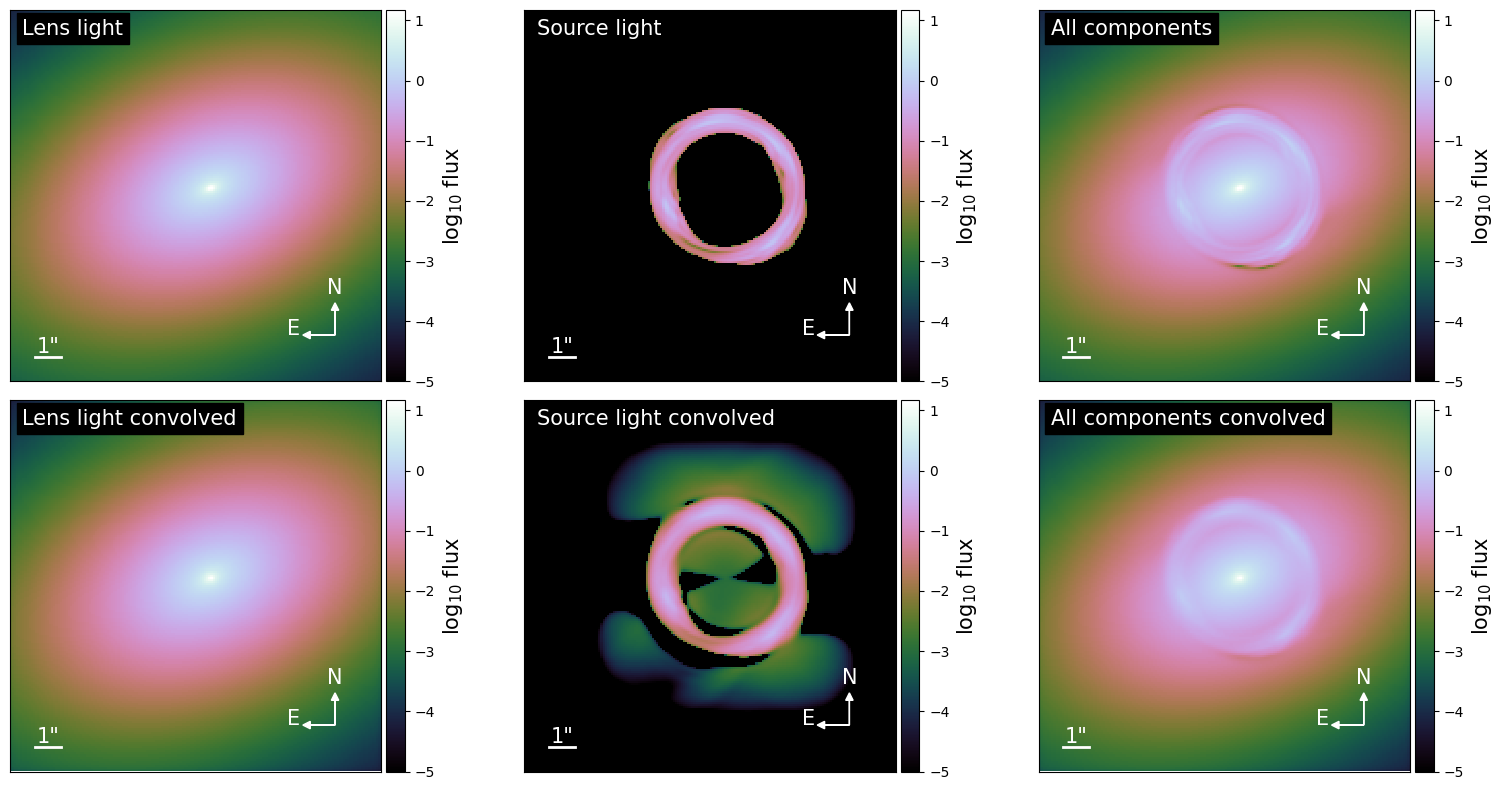

{'kwargs_lens': [{'theta_E': 2.6234799598938725, 'gamma': 2.0, 'e1': 0.142161430758523, 'e2': -0.1426860984410649, 'center_x': -0.49092840932498305, 'center_y': 0.23115683900699}, {'gamma1': 0.03947744111555052, 'gamma2': -0.010428377966142974, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -3.3538245345062894, 'R_sersic': 0.49875969567106343, 'n_sersic': 1.0, 'e1': 0.6428243954845126, 'e2': 0.03968393485753815, 'center_x': -0.595891320828988, 'center_y': 0.17753069964287801}, {'amp': array([ 2.11623016e+02, -2.67091963e+01,  2.20951893e+01,  5.02333803e+01,
       -8.18051948e+00,  4.28520032e+01, -5.05879005e+00, -8.26896458e+00,
       -6.31029253e+00,  5.40316403e+00,  4.39203433e+01, -4.21428709e+00,
        2.15606706e+01,  1.69992533e+00,  2.95454848e+01, -8.09116619e+00,
        7.71316500e+00,  5.89065456e+00,  1.83879914e+00, -9.38060028e+00,
        7.81765446e+00,  4.30292185e+00, -6.71012282e+00, -3.01623053e+00,
        4.75863125e+00, -5.90463088e+00,  4.70058233e+00

In [23]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result_mcmc,
    arrow_size=0.02, cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
    linear_solver=kwargs_constraints.get('linear_solver', True)
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(
    ax=axes[0, 2], v_min=-3, v_max=3, cmap='RdBu_r'
)
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02,
    numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(
    left=None, bottom=None, right=None,
    top=None, wspace=0., hspace=0.05
)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text='Lens light', lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text='Lens light convolved', lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text='Source light', source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text='Source light convolved', source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2], text='All components', source_add=True,
    lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 2], text='All components convolved', source_add=True,
    lens_light_add=True, point_source_add=True
)
f.tight_layout()
f.subplots_adjust(
    left=None, bottom=None, right=None,
    top=None, wspace=0., hspace=0.05
)
plt.show()
print(kwargs_result_mcmc)

In [45]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 5070
    thin = 10
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)

output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]

output_path = "DESIJ1101-0602_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

Number of evaluations in the MCMC process: 415360
415360
Shape of shortened_samples_mcmc: (1040, 19)


In [50]:
lens_central_model_list = [lens_light_model_list[0], lens_light_model_list[1]]

light_model_central = LightModel(lens_central_model_list)
analysis_central = LightProfileAnalysis(light_model_central)

# Providing the lens light results from MCMC
kwargs_central_light = [
    kwargs_result_mcmc["kwargs_lens_light"][0],
    kwargs_result_mcmc["kwargs_lens_light"][1],
]

# Calculate the half-light radius of central lens
half_light_radius_mcmc = analysis_central.half_light_radius(
    kwargs_central_light, grid_spacing=0.01, grid_num=10 / 0.01
)
# Calculate the total flux of central lens
total_flux_central_mcmc = analysis_central.flux_components(
    kwargs_central_light, grid_spacing=0.01, grid_num=10 / 0.01
)

print("Half-light radius:", half_light_radius_mcmc)
print("Total Central lens flux:", total_flux_central_mcmc)

Half-light radius: 1.5258232967155798
Total Central lens flux: ([556.1028276375639, 2350.7541374722387], [0.49447977208375277, 1.7659991860134026])


## Light and Mass ellipticity check after MCMC

In [51]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.6646996004995729,
light_q: 0.62929304739842


## Mass and Light's Ellipticity of the Lens Galaxy + Shear

In [52]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

result_mass_gamma1 = kwargs_result_mcmc["kwargs_lens"][1]["gamma1"]
result_mass_gamma2 = kwargs_result_mcmc["kwargs_lens"][1]["gamma2"]

phi_mass, q_mass = ellipticity2phi_q(result_mass_e1, result_mass_e2)
phi_light, q_light = ellipticity2phi_q(result_light_e1, result_light_e2)
phi_shear, gamma_shear = shear_cartesian2polar(result_mass_gamma1, result_mass_gamma2)

print("phi_mass: {}, q_mass: {}".format(phi_mass, q_mass))

print("phi_light: {}, q_light: {}".format(phi_light, q_light))

print("phi_shear: {}, gamma_shear: {}".format(phi_shear, gamma_shear))

phi_mass: -0.39362004297697906, q_mass: 0.6646996004995729
phi_light: -0.4175305171025765, q_light: 0.62929304739842
phi_shear: -0.12913054554262096, gamma_shear: 0.04083159835270345


## Convert and Store the Uncertainty of the parameters

In [57]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}

# renaming parameters
parameter_values["theta_E"] = parameter_values.pop("theta_E_lens0")
parameter_values["gamma"] = parameter_values.pop("gamma_lens0")
parameter_values["center_x_mass"] = parameter_values.pop("center_x_lens0")
parameter_values["center_y_mass"] = parameter_values.pop("center_y_lens0")
parameter_values["center_x_light"] = parameter_values.pop("center_x_lens_light0")
parameter_values["center_y_light"] = parameter_values.pop("center_y_lens_light0")

parameter_values["gamma"] = 2 # value of gamma is kept fixed at 2.0 for the mcmc run

# adding Half-light Radius
parameter_values["R_eff_light"] = half_light_radius_mcmc

print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E': [2.623908291926923, 0.0025155880434124533, 0.00222293316638833], 'gamma': 2, 'center_x_mass': [-0.487593641016246, 0.003658461018897885, 0.0034121362009170153], 'center_y_mass': [0.23242497184722957, 0.002843883654033541, 0.0023112127223889334], 'center_x_light': [-0.48949734304325976, 0.0013623734261165032, 0.0014040648171345094], 'center_y_light': [0.19686014212147804, 0.0010223570254715153, 0.0011000462371583974], 'R_eff_light': 1.5258232967155798}


In [58]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = ellipticity2phi_q(prior_samples[j][i], prior_samples[j][i + 1])
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = shear_cartesian2polar(prior_samples[k][i], prior_samples[k][i + 1])
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E': [2.623908291926923, 0.0025155880434124533, 0.00222293316638833], 'gamma': 2, 'center_x_mass': [-0.487593641016246, 0.003658461018897885, 0.0034121362009170153], 'center_y_mass': [0.23242497184722957, 0.002843883654033541, 0.0023112127223889334], 'center_x_light': [-0.48949734304325976, 0.0013623734261165032, 0.0014040648171345094], 'center_y_light': [0.19686014212147804, 0.0010223570254715153, 0.0011000462371583974], 'R_eff_light': 1.5258232967155798, 'phi_mass': [-0.3931233070507984, 0.009272313138577293, 0.008745953307221999], 'q_mass': [0.6639504986392432, 0.005668248668991738, 0.0071368511030668325], 'phi_shear': [-0.12441334226267725, 0.022550941786294118, 0.027296208660549798], 'gamma_shear': [0.04148339887065264, 0.001839011523388695, 0.0022109828308555235], 'phi_light': [-0.4170887210774408, 0.002717798387937176, 0.00239157639614207], 'q_light': [0.6285767969450153, 0.0014043368914732346, 0.0013081150153899657]}


## Creating YAML File

In [59]:
# marge parameter_values and environment_values
print(parameter_values)
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1101-0602_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

{'theta_E': [2.623908291926923, 0.0025155880434124533, 0.00222293316638833], 'gamma': 2, 'center_x_mass': [-0.487593641016246, 0.003658461018897885, 0.0034121362009170153], 'center_y_mass': [0.23242497184722957, 0.002843883654033541, 0.0023112127223889334], 'center_x_light': [-0.48949734304325976, 0.0013623734261165032, 0.0014040648171345094], 'center_y_light': [0.19686014212147804, 0.0010223570254715153, 0.0011000462371583974], 'R_eff_light': 1.5258232967155798, 'phi_mass': [-0.3931233070507984, 0.009272313138577293, 0.008745953307221999], 'q_mass': [0.6639504986392432, 0.005668248668991738, 0.0071368511030668325], 'phi_shear': [-0.12441334226267725, 0.022550941786294118, 0.027296208660549798], 'gamma_shear': [0.04148339887065264, 0.001839011523388695, 0.0022109828308555235], 'phi_light': [-0.4170887210774408, 0.002717798387937176, 0.00239157639614207], 'q_light': [0.6285767969450153, 0.0014043368914732346, 0.0013081150153899657]}
YAML file 'DESIJ1101-0602_point_estimates.yml' created